# Stabilizing selection

Explore the consequences of stabilizing selection on LD

Yair, S., & Coop, G. (2022). Population differentiation of polygenic score predictions under stabilizing selection. Philosophical Transactions of the Royal Society of London. Series B, Biological Sciences, 377(1852), 20200416.

From Yair and Coop Appendix A1:

$$
\begin{align}
W(\vec{r}) = \mathrm{exp}\left( -\frac{r^2}{2w^2} \right)
\end{align}
$$

where $r = \|\vec{r}\| $ is the phenotypic distance from optimum for an individual with vector of phenotypes $\vec{r}$ and $w$ the width of the fitness peak.

Here we'll define $\| \vec{r} \|$ as the absolute value of the sum of effect sizes for mutations:

$$
\begin{align}
r &= \sum_{i=1}^n a_i 
\end{align}
$$

## Model of stabilizing selection

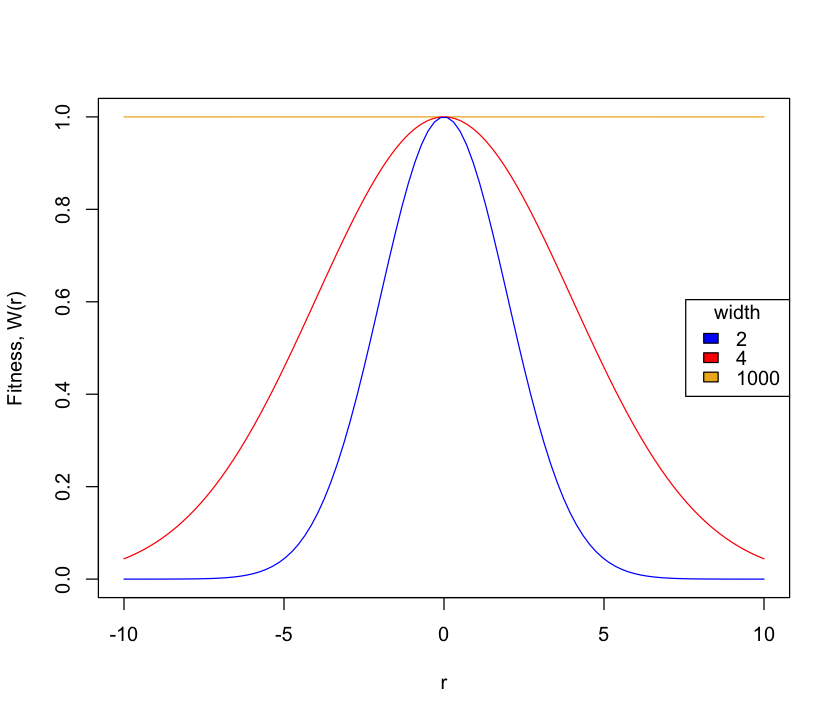

In [2]:
r <- rnorm(100)

x <- seq(-10,10, length=100)

options(repr.plot.width=7, repr.plot.height=6)
w <- 1000
plot(x, exp(-x^2/(2*w^2)), type='l', xlab='r', ylab='Fitness, W(r)', ylim=c(0,1), col='goldenrod2')
w <- 4
points(x, exp(-x^2/(2*w^2)), type='l', xlab='r', ylab='Fitness, W(r)', col='red')
w <- 2
points(x, exp(-x^2/(2*w^2)), type='l', xlab='r', ylab='Fitness, W(r)', col='blue')
legend('right', c('2','4','1000'), fill=c('blue', 'red', 'goldenrod2'), title = 'width')



$$
\begin{align}
s &\approx \frac{\sum_{i=1}^{n}a_{i}^2}{w^2} \\
\end{align}
$$

where $a_i$ denotes allele's effect on trait $i$ and $w$ is the width of stabilizing peak under Gaussian stabilizing selection.

## r06.1 (stabilizing selection, epistasis)

Publication Fig 6, Supp Fig 12

Here we show the LD and $\xi$ results from a forward evoluationary
simulation on a stabilizing selection (epistatic) model. This demonstrates
positive LD between opposite-effect SNPs, and negative LD between
concordant-effect SNPs.

- Fixed population size N=10000
- Recombination 1e-8
- Mutation rate 1e-8
- For each run, variant effect of either $+\beta$ or $-\beta$
- No downsampling for LD calculations
- 5000 iterations

### Simulation run

```bash
pwd
# /n/data2/hms/dbmi/sunyaev/lab/cchiang/expts/stabilizing_sim_2021-09-28/r06.1
```

```bash
RUN=r06.1
RECOMB=1e-8
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
MU=1e-8

mkdir -p log
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, BETA ${BETA}
        sbatch \
            --array=4801-5000%20 \
            -c 1 \
            -t 0-01:00 \
            --mem=500M \
            -p short \
            -J $RUN.w${WIDTH}.b${BETA} \
            -o log/$RUN.w${WIDTH}.b${BETA}.%a.out \
            ./submit_array.sh \
                -N ${N} -R ${REG_SIZE} -w ${WIDTH} -b ${BETA} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

### Compute snp-pair effect

Here we calculate the snp-pair effect $\xi$ in different slices of the data.

This is a rescue of `slim_generator.sh`, which runs `parse_vcf_gravel.py` because in the default run, it uses different definitions of low/common allele frequencies. Therefore, we can reuse the simulation run but just summarize the snp-pair effect over different variant pairs.

The relevant script here is `calc_covar.py`, which computes the covariance among the desired classes

In this run class is defined as follows. (note that ancestral/derived status is being ignored here per Martin's protocol for the empirical data):
- Low frequency: MAF 0.05% - 5%
- Common: MAF 5%-95% (inclusive)
- Split into positive and negative LD classes.

In the publication, we only present the data for WIDTH=2, BETA=1e-1.

```bash
RUN=r06.1

mkdir -p log
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, BETA ${BETA}
        sbatch \
            --array=1-500%20 \
            -c 1 \
            -t 0-00:30 \
            --mem=500M \
            -p short \
            -J covar.$RUN.w${WIDTH}.b${BETA} \
            -o log/covar.$RUN.w${WIDTH}.b${BETA}.%a.out \
            ./submit_covar_batch.sh \
                -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=10000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-12:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_type.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep PEND | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

Compile summary stats for covariation only

```bash
N=10000
MIN_FREQ=0

for BETA in 1e-1 # 1e-2 1e-3 1e-4
do
    for WIDTH in 2 # 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-12:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_cov.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep PEND | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash
N=10000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        cat w${WIDTH}/b${BETA}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

merge covariance stats across selection coeff
```bash

echo "beta,width,bin,class,corr_class,dist,prod,corr,cov" | gzip -c > summary_cov.min_frq_0.txt.gz
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        OUTFILE=$OUTDIR/summary_cov.min_frq_${MIN_FREQ}.txt
        cat $OUTFILE | sed 1d \
            | awk -v BETA=$BETA -v WIDTH=$WIDTH '{ print BETA","WIDTH","$0 }'
    done
done | gzip -c >> summary_cov.min_frq_0.txt.gz
```

### Figures

#### Detailed LD fig

In [1]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [2]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [3]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


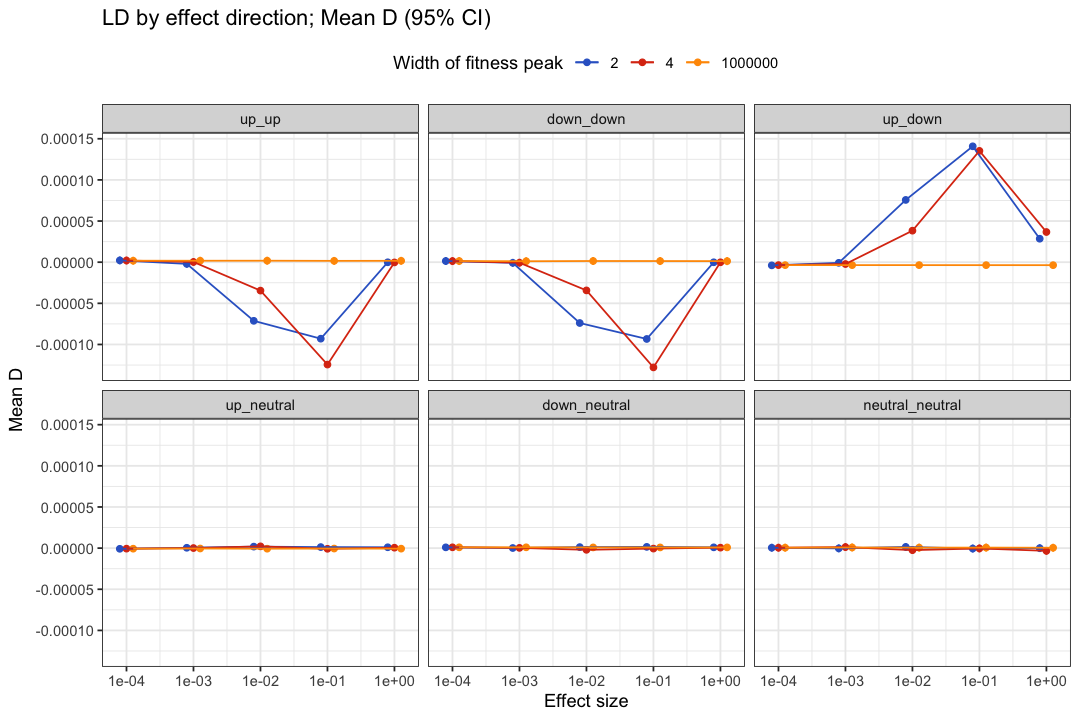

In [4]:
options(repr.plot.width=9, repr.plot.height=6)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all",], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean D')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

#### Simplified fig

In [5]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [6]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type,
                   levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

dat$type.simp <- factor(dat$type, levels = c("up_up", "down_down",
                                             "up_down",
                                            "up_neutral", "down_neutral", "neutral_neutral",
                                             "all"),
                  labels = c("Concordant effect SNP-pairs", "Concordant effect SNP-pairs",
                             "Opposite effect SNP-pairs",
                             "Neutral SNP-pairs", "Neutral SNP-pairs", "Neutral SNP-pairs",
                             "All"))

In [7]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type.simp) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


pdf 
  2

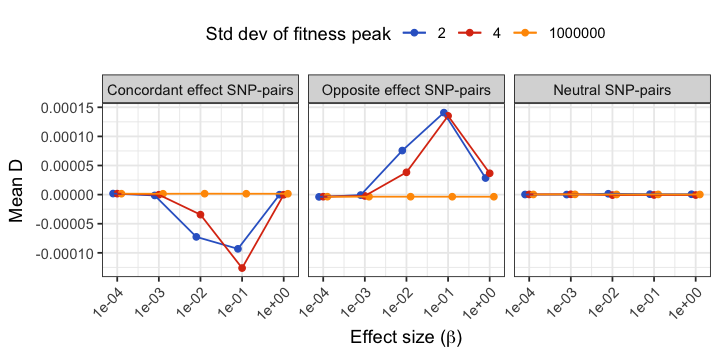

In [8]:
w <- 6
h <- 3

options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type.simp!="All" &
#                              dat_summary$type.simp!="Opposite effect SNP-pairs" &
                             dat_summary$beta < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type.simp ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
# p <- p + ggtitle(paste0('LD by effect direction',
#                         '; Mean D (', ci*100,
#                         '% CI)'))
# p <- p + xlab('Effect size')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + xlab(expression(paste("Effect size (", beta, ")")))
p <- p + ylab('Mean D')
p <- p + labs(color='Std dev of fitness peak') + theme(legend.position="top")
print(p)

pdf('figs/ld_beta_sign.pdf', h=h, w=w)
print(p)
dev.off()

#### Beta Covariance detail

In [9]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [10]:
dat <- read.csv('summary_cov.min_frq_0.txt.gz', header=T)
dat <- dat[!is.na(dat$corr_class),]

In [11]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(beta, width, bin, class, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'beta', 'width', 'bin', 'class'. You can override using the `.groups` argument.


In [12]:
# rename low to rare
dat_summary$class <- factor(dat_summary$class, levels = c("low-low", "common-low", "common-common"),
                  labels = c("low-low", "common-low", "common-common"))

In [13]:
# rename ranges
dat_summary$bin <- factor(dat_summary$bin, levels = c("100", "1000", "10000", "100000"),
                  labels = c("0-100bp", "100bp-1kb", "1-10kb", "10-100kb"))

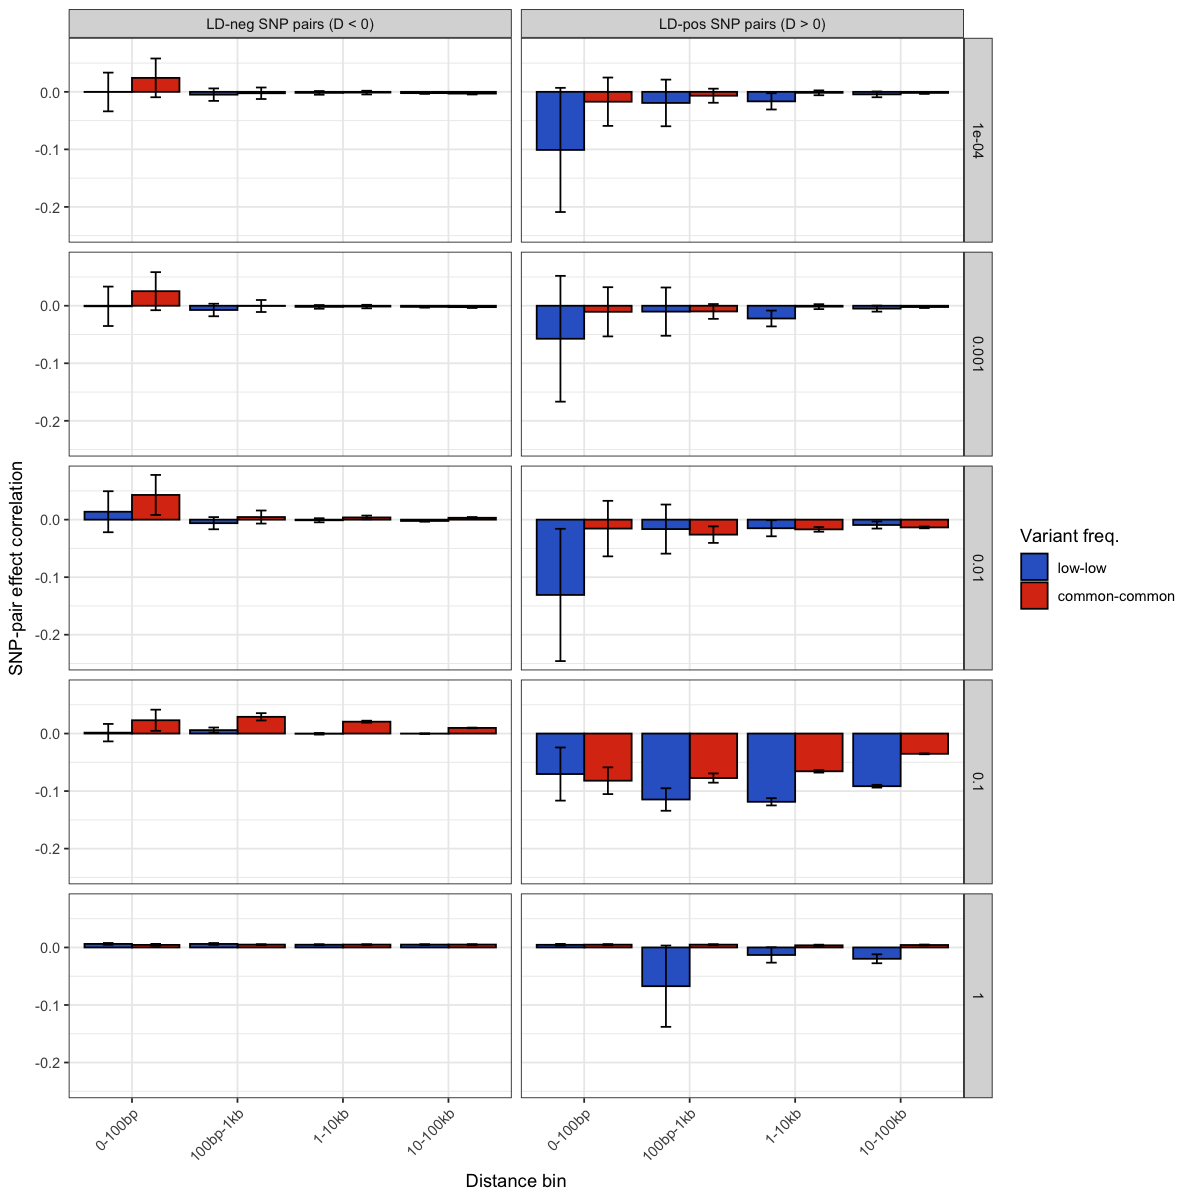

In [14]:
# w <- 6
# h <- 2.5

w <- 10
h <- 10


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg SNP pairs (D < 0)", "LD-pos SNP pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[!is.na(dat_summary$class)
                             & dat_summary$class != "common-low"
                             & dat_summary$width==2
#                              & dat_summary$beta==1e-1
                             ,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))

# p <- p + facet_grid(beta  ~ corr_class,
#                     labeller = labeller(corr_class = corr_class.labs))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w2_beta_all.pdf', h=h, w=w)
# print(p)
# dev.off()

In [15]:
# write data to csv
write.csv(p$data, 'figs/SNP_effect_pair_corr_w2_beta_all.csv')

##### Beta Covariance simple (main text Fig. 6)

Stratified by distance

pdf 
  2

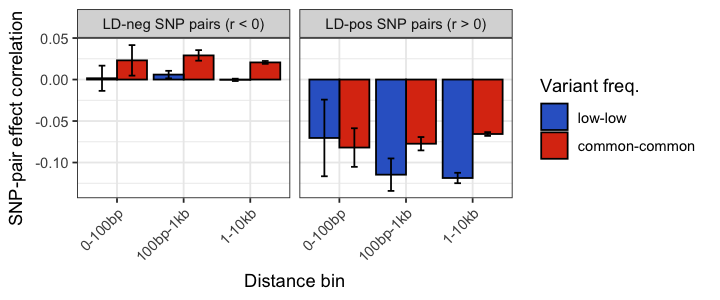

In [16]:
w <- 6
h <- 2.5

# w <- 10
# h <- 10


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg SNP pairs (r < 0)", "LD-pos SNP pairs (r > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[!is.na(dat_summary$class)
                             & dat_summary$bin != "10-100kb"
                             & dat_summary$class != "common-low"
                             & dat_summary$width==2
                             & dat_summary$beta==1e-1
                             ,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))

p <- p + facet_grid(.  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

pdf('figs/SNP_effect_pair_corr_w2_beta1e-1.pdf', h=h, w=w)
print(p)
dev.off()

In [17]:
# Output raw data for publication:
out.data <- dat_summary[!is.na(dat_summary$class)
                             & dat_summary$bin != "10-100kb"
                             & dat_summary$class != "common-low"
                             & dat_summary$width==2
                             & dat_summary$beta==1e-1
                             ,] %>%
        mutate(CI95.low = mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)) %>%
        mutate(CI95.high = mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE))

write.csv(out.data, 'figs/fig5_data.csv')

##### Beta Covariance simple (main text Fig. 6)
___Reviewer 2 requested figure with addition of the 10kb - 100kb window___

pdf 
  2

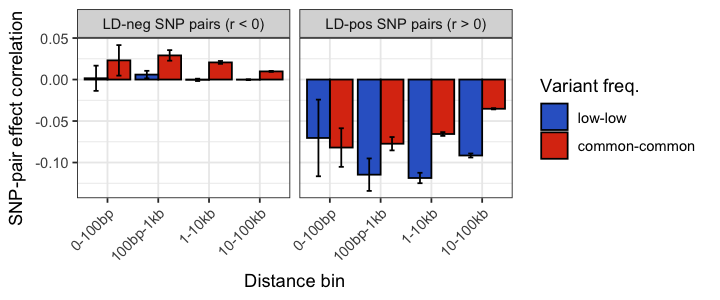

In [18]:
w <- 6
h <- 2.5

# w <- 10
# h <- 10


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg SNP pairs (r < 0)", "LD-pos SNP pairs (r > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[!is.na(dat_summary$class)
                             & dat_summary$class != "common-low"
                             & dat_summary$width==2
                             & dat_summary$beta==1e-1
                             ,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))

p <- p + facet_grid(.  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

pdf('figs/SNP_effect_pair_corr_w2_beta1e-1.pdf', h=h, w=w)
print(p)
dev.off()

In [19]:
# Output raw data for publication:
out.data <- dat_summary[!is.na(dat_summary$class)
                             & dat_summary$class != "common-low"
                             & dat_summary$width==2
                             & dat_summary$beta==1e-1
                             ,] %>%
        mutate(CI95.low = mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)) %>%
        mutate(CI95.high = mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE))

write.csv(out.data, 'figs/fig5_data_with_10-100kb.csv')

#### Beta covariance (Stratified by LD)

In [322]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [323]:
dat <- read.csv('summary_cov.ld.min_frq_0.txt.gz', header=T)
dat <- dat[!is.na(dat$corr_class),]

In [324]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(beta, width, bin, class, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'beta', 'width', 'bin', 'class'. You can override using the `.groups` argument.


In [325]:
# rename low to rare
dat_summary$class <- factor(dat_summary$class, levels = c("low-low", "common-low", "common-common"),
                  labels = c("low-low", "common-low", "common-common"))

In [326]:
# rename ranges
dat_summary$bin <- factor(dat_summary$bin, levels = c("100", "1000", "10000", "100000"),
                  labels = c("0-100bp", "100bp-1kb", "1-10kb", "10-100kb"))

pdf 
  2

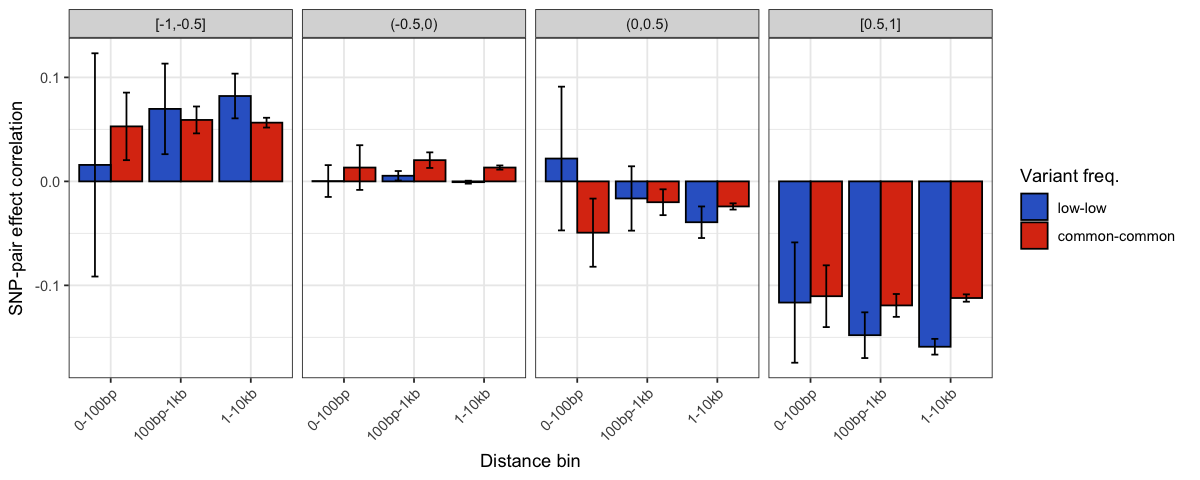

In [327]:
w <- 10
h <- 4

# w <- 10
# h <- 10


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# # New facet label names for corr_class variable
# corr_class.labs <- c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")
# names(corr_class.labs) <- c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")

# dat$corr_class <- ordered(dat$corr_class, levels=c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]"))

p <- ggplot(data=dat_summary[!is.na(dat_summary$class)
                             & dat_summary$bin != "10-100kb"
                             & dat_summary$class != "common-low"
                             & dat_summary$width==2
                             & dat_summary$beta==1e-1
                             ,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))

p <- p + facet_grid(.  ~ factor(corr_class, levels=c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")))
# p <- p + facet_grid(.  ~ corr_class,
#                     labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

pdf('figs/SNP_effect_pair_corr_w2_beta1e-1_ldbins.pdf', h=h, w=w)
print(p)
dev.off()

#### Beta covariance, no distance bins
- Stratified by LD
- No distance bins

In [283]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [284]:
dat <- read.csv('summary_cov.ld.nodist.min_frq_0.txt.gz', header=T)

In [290]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(beta, width, bin, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'beta', 'width', 'bin'. You can override using the `.groups` argument.


In [291]:
# rename ranges
dat_summary$bin <- factor(dat_summary$bin, levels = c("10000", "100000"),
                  labels = c("0-10kb", "10-100kb"))

pdf 
  2

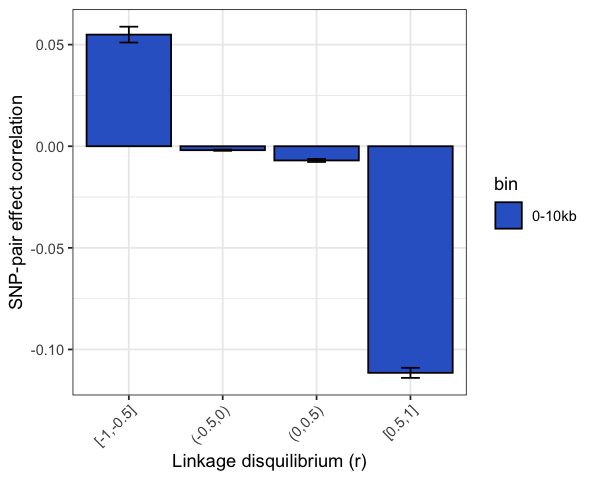

In [310]:
# w <- 10
# h <- 4

w <- 5
h <- 4

options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# # New facet label names for corr_class variable
# corr_class.labs <- c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")
# names(corr_class.labs) <- c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")

# dat$corr_class <- ordered(dat$corr_class, levels=c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]"))

p <- ggplot(data=dat_summary[dat_summary$bin=='0-10kb'
                             & dat_summary$width==2
                             & dat_summary$beta==1e-1
                             ,],
            aes(x=factor(corr_class, levels=c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")), y=mean,
               fill=bin)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=factor(corr_class, levels=c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))

# p <- p + facet_grid(.  ~ factor(corr_class, levels=c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")))
# p <- p + facet_grid(.  ~ corr_class,
#                     labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Linkage disquilibrium (r)')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
# p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

pdf('figs/SNP_effect_pair_corr_w2_beta1e-1_ldbins_nodist.pdf', h=h, w=w)
print(p)
dev.off()

## r06.2 (no epistasis)

Here, we try to differentiate the stabilizing selection model from the null hypothesis
(non-epistatic regime). We know that without epistasis we will see Hill-Robertson
interference causing negative LD in weakly selected variants.

- simulation of __directional selection__ (only neutral and trait decreasing variants)
- Fixed population size N=10000
- Recombination
- No downsampling for LD calculations
- 2023-08-28: Problem with colliding seeds under certain selection parameters, so multiplying SEED by WIDTH
- (Publication quality version of `r04.3`)

```bash
WIDTH=2
BETA=1e-1
OUTPREFIX=test

time slim \
    -s 10 \
    -d pop_size=10000 \
    -d width=${WIDTH} \
    -d beta=${BETA} \
    -d dom_coeff=0.5 \
    -d reg_length=100000 \
    -d recomb_rate=1e-8 \
    -d mu=1e-8 \
    -d "out_prefix='${OUTPREFIX}'" \
    slim_cmd.slim

```

### Simulation run

```bash
pwd
# /n/data2/hms/dbmi/sunyaev/lab/cchiang/expts/stabilizing_sim_2021-09-28/r06.2
```

```bash
RUN=r06.2
RECOMB=1e-8
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
MU=1e-8

mkdir -p log
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, BETA ${BETA}
        sbatch \
            --array=2101-2700%50 \
            -c 1 \
            -t 0-01:00 \
            --mem=500M \
            -p short \
            -J $RUN.w${WIDTH}.b${BETA} \
            -o log/$RUN.w${WIDTH}.b${BETA}.%a.out \
            ./submit_array.sh \
                -N ${N} -R ${REG_SIZE} -w ${WIDTH} -b ${BETA} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=10000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-12:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_type.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep PEND | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

Compile summary stats for covariation only
- This is not needed

```bash
N=10000
MIN_FREQ=0

for BETA in 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-12:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_cov.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep PEND | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash
N=10000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        cat w${WIDTH}/b${BETA}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

merge covariance stats across selection coeff
```bash

echo "beta,width,bin,class,corr_class,dist,prod,corr,cov" | gzip -c > summary_cov.min_frq_0.txt.gz
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        OUTFILE=$OUTDIR/summary_cov.min_frq_${MIN_FREQ}.txt
        cat $OUTFILE | sed 1d \
            | awk -v BETA=$BETA -v WIDTH=$WIDTH '{ print BETA","WIDTH","$0 }'
    done
done | gzip -c >> summary_cov.min_frq_0.txt.gz
```

### Figures

#### Detailed LD fig

In [218]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.2')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [219]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [220]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


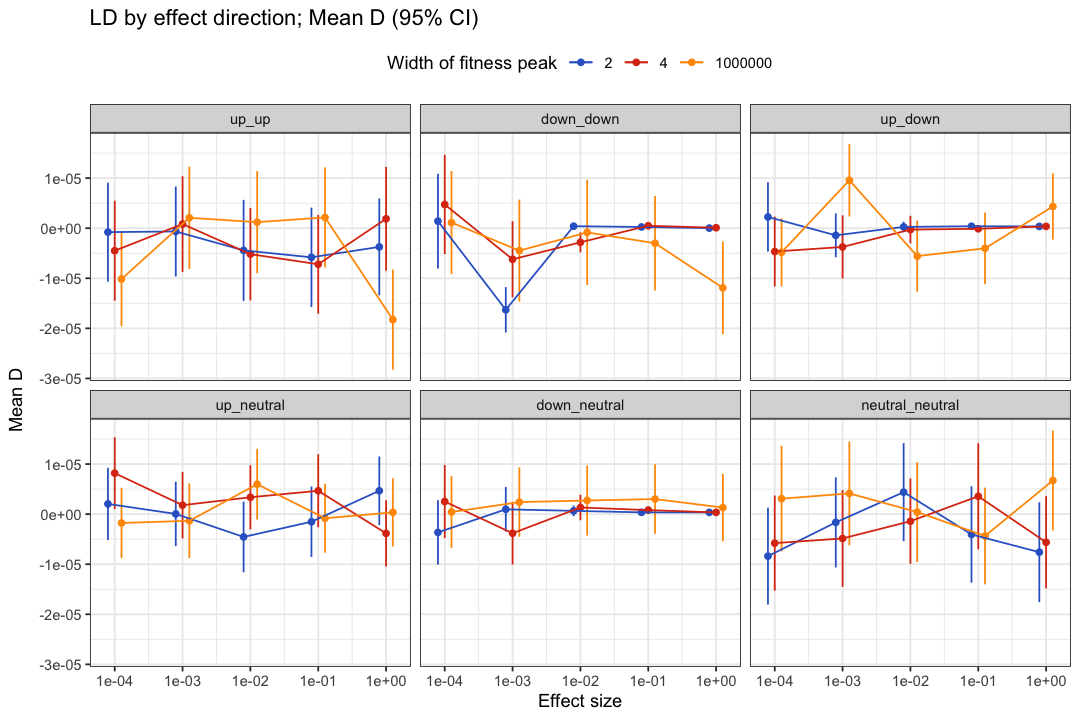

In [221]:
options(repr.plot.width=9, repr.plot.height=6)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all",], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean D')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

#### Simplified fig

In [222]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.2')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [223]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type,
                   levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

dat$type.simp <- factor(dat$type, levels = c("up_up", "down_down",
                                             "up_down",
                                            "up_neutral", "down_neutral", "neutral_neutral",
                                             "all"),
                  labels = c("Concordant effect SNP-pairs", "Concordant effect SNP-pairs",
                             "Opposite effect SNP-pairs",
                             "Neutral SNP-pairs", "Neutral SNP-pairs", "Neutral SNP-pairs",
                             "All"))

In [224]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type.simp) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


pdf 
  2

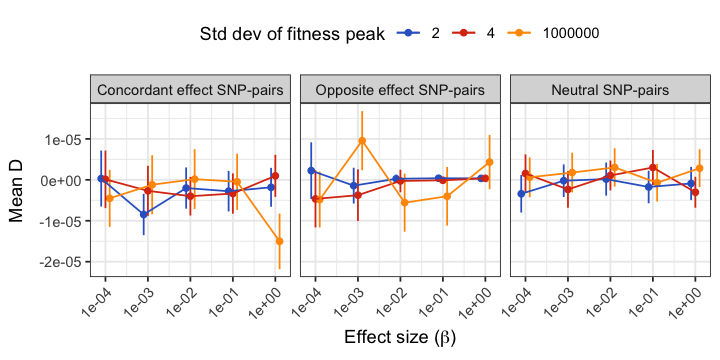

In [225]:
w <- 6
h <- 3

options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type.simp!="All" &
#                              dat_summary$type.simp!="Opposite effect SNP-pairs" &
                             dat_summary$beta < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type.simp ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
# p <- p + ggtitle(paste0('LD by effect direction',
#                         '; Mean D (', ci*100,
#                         '% CI)'))
# p <- p + xlab('Effect size')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + xlab(expression(paste("Effect size (", beta, ")")))
p <- p + ylab('Mean D')
p <- p + labs(color='Std dev of fitness peak') + theme(legend.position="top")
print(p)

pdf('figs/ld_beta_sign.pdf', h=h, w=w)
print(p)
dev.off()

#### Beta covariance

In [226]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.2')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [227]:
dat <- read.csv('summary_cov.min_frq_0.txt.gz', header=T)
dat <- dat[!is.na(dat$corr_class),]

In [228]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(beta, width, bin, class, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'beta', 'width', 'bin', 'class'. You can override using the `.groups` argument.


In [229]:
# rename low to rare
dat_summary$class <- factor(dat_summary$class, levels = c("low-low", "common-low", "common-common"),
                  labels = c("rare-rare", "common-rare", "common-common"))

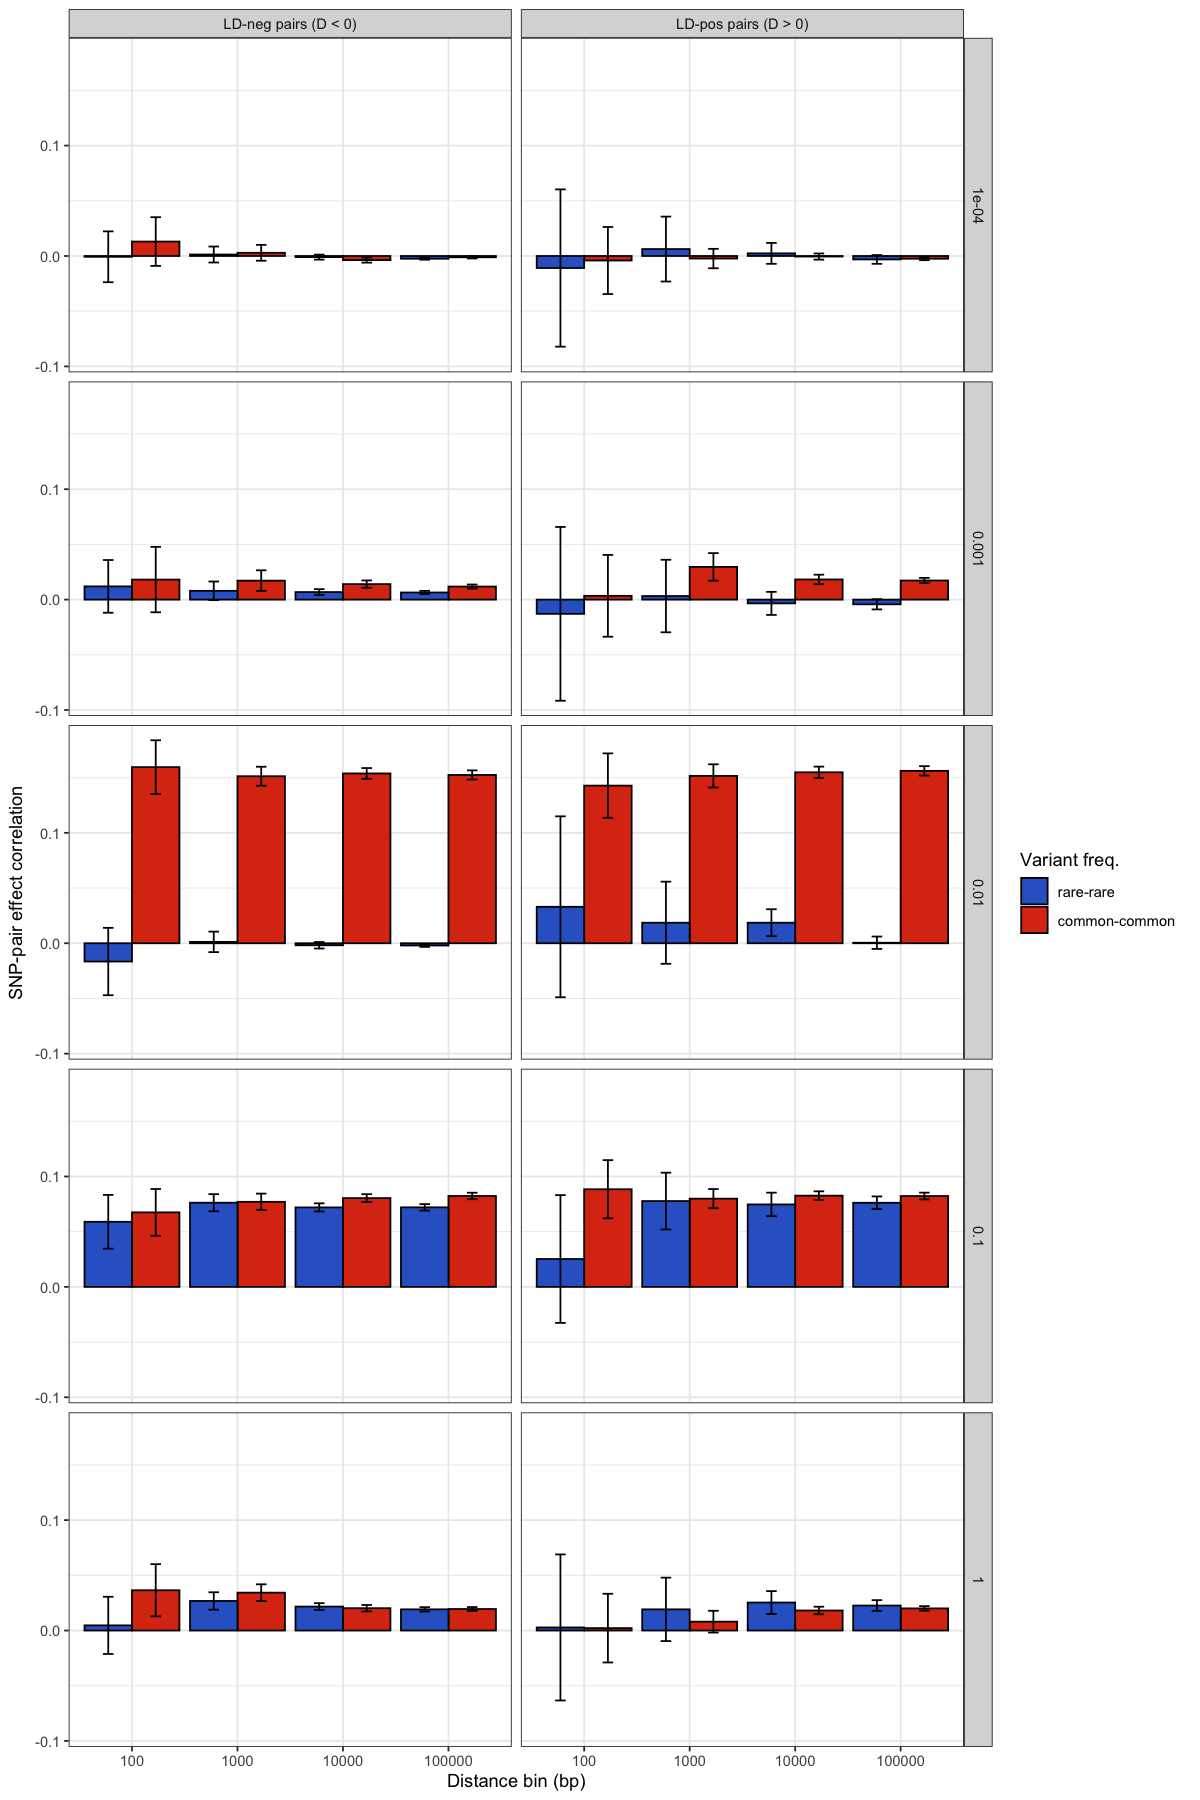

In [230]:
# w <- 6
# h <- 2.5

w <- 10
h <- 15


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[dat_summary$class != "common-rare" &
                             !is.na(dat_summary$class) &
                             dat_summary$width==2,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w2_beta1e-2.pdf', h=h, w=w)
# print(p)
# dev.off()

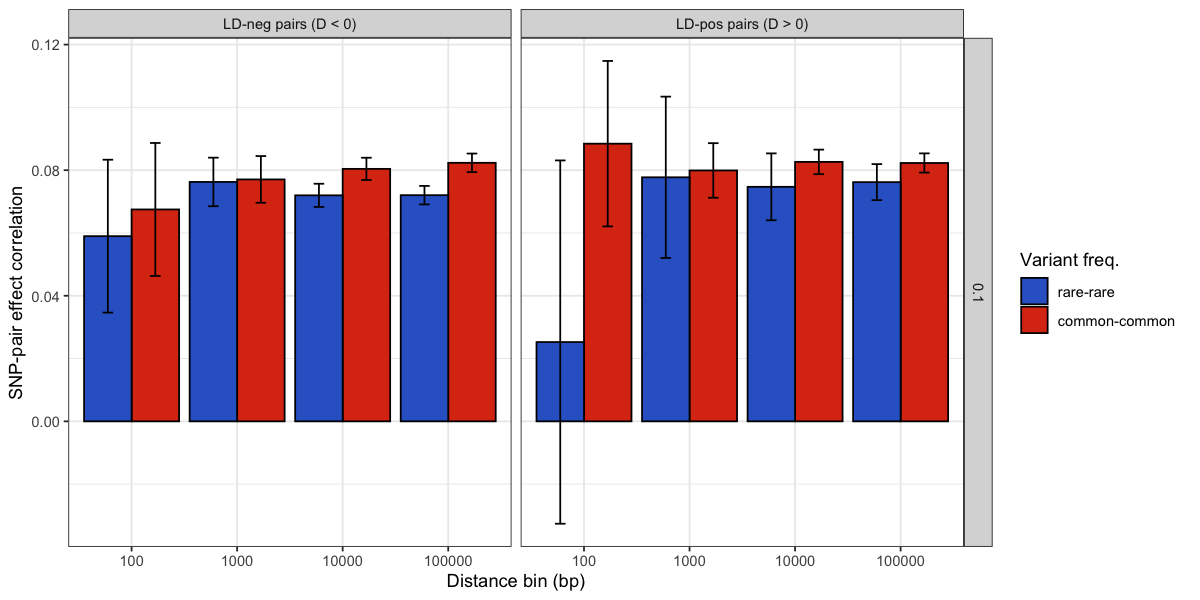

In [231]:
# w <- 6
# h <- 2.5

w <- 10
h <- 5


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[dat_summary$class != "common-rare" &
                             !is.na(dat_summary$class) &
                             dat_summary$width==2 &
                             dat_summary$beta==1e-1,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w2_beta1e-2.pdf', h=h, w=w)
# print(p)
# dev.off()